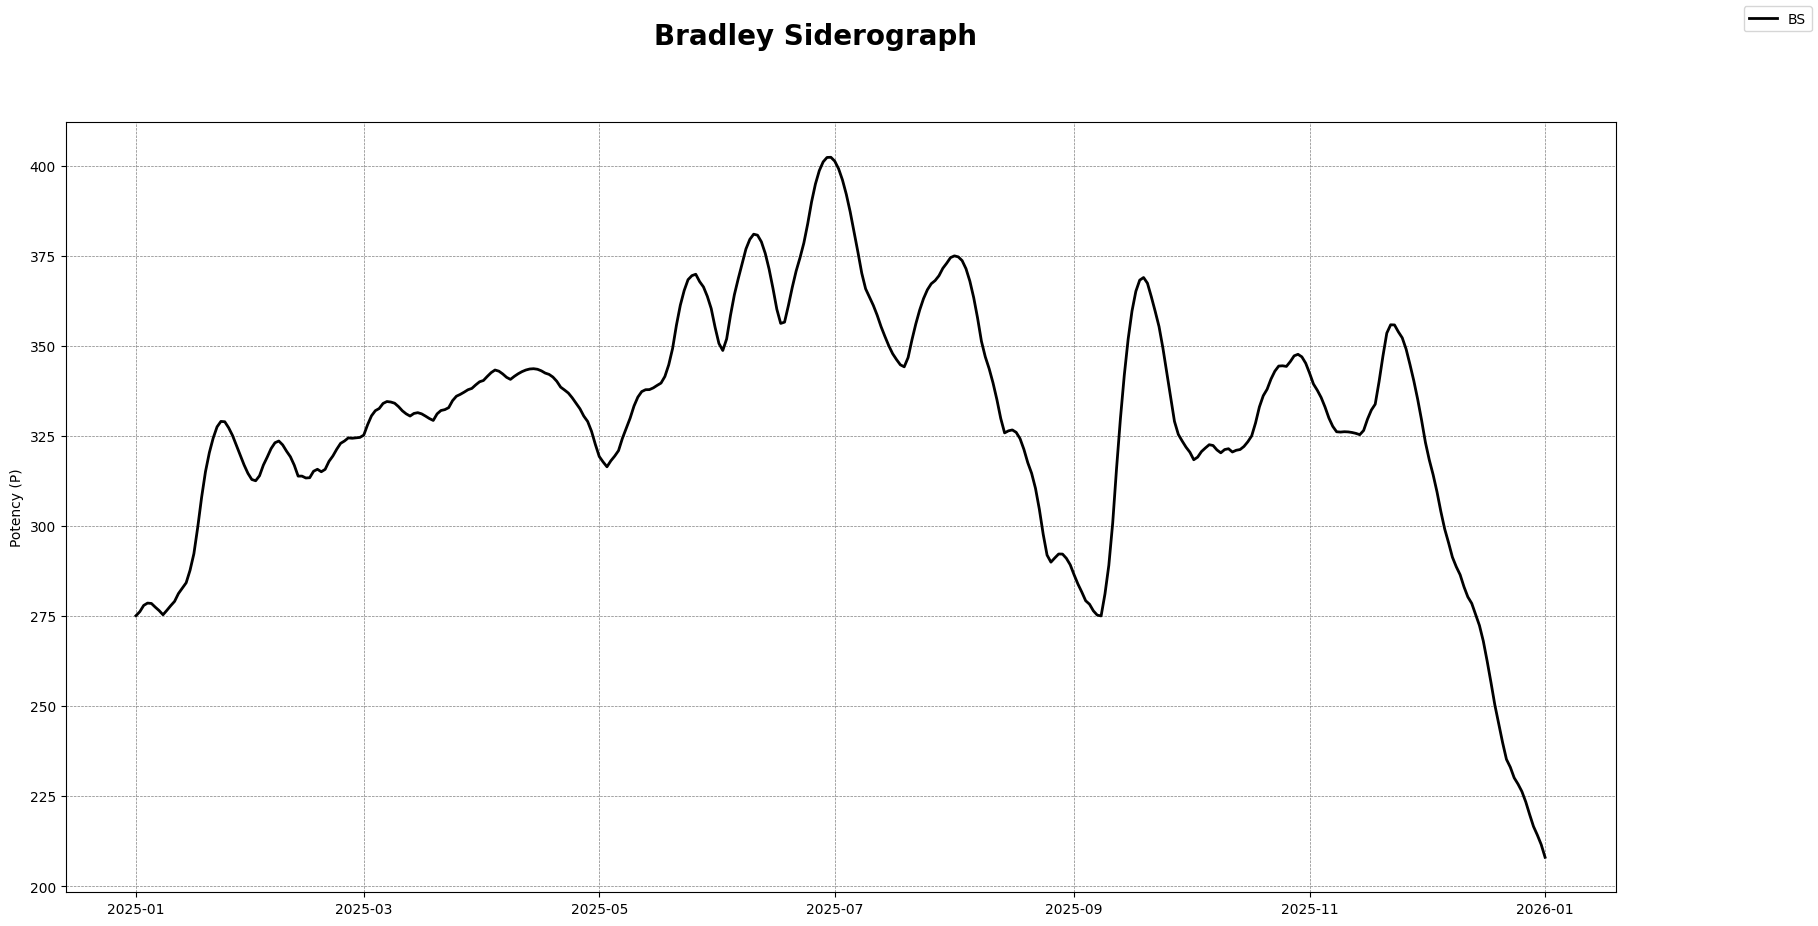

In [1]:
# =================================================================================================
#  BRADLEY-STYLE SIDEROGRAPH  ─  PYTHON IMPLEMENTATION
#
#  References
#  ----------
#  • Donald A. Bradley, “Stock-Market Prediction, The Planetary Barometer” (Llewellyn, 1950/1984).
#      •  p.24  – Figure 6, sine-curve weighting for 15° orbs               (amplitude = 10 → 0)
#      •  p.26  – Figure 7, Valency of Conjunctions                         (+ / – sign table)
#      •  p.30  – Figure 8, combination of M, L and D factors → P           (P = M + 4 (L + D))
#      •  p.34  – Figure 10, example graph of P plotted against the Dow     (the “Siderograph”)
#
#  This file reproduces Bradley’s algorithm and extends it with heliocentric
#  and planetocentric reference frames.  The only dependency that is not in the
#  Python standard library is `pyswisseph`, a thin wrapper around the Swiss Ephemeris.
#  ---------------------------------------------------------------------------------
#  pip install --user pyswisseph
# =================================================================================================
import os
# path to binary ephemeris data files
# for download info: https://www.astro.com/ftp/swisseph/ephe/
# os.environ['SE_EPHE_PATH'] = '/path/to/swisseph/ephe/'

import swisseph as swe                 # Swiss Ephemeris (astronomical calculations)
import datetime                        # Handling civil calendar dates
from typing import Dict, List, Tuple
import numpy as np                     # Vectorised arithmetic
import matplotlib.pyplot as plt        # Plotting the final graph
import pandas as pd                    # Tabular data storage/manipulation
from itertools import combinations     # To list every 2-planet pair
from functools import reduce           # Functional “fold” for influence summing
import re                              # Fast regex search for column names
import math


# ----------------------------------------------------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------
#  REFERENCE FRAME
#  ---------------
#  Bradley worked exclusively with apparent geocentric positions.  The two extra
#  options below allow researchers to replicate heliocentric (Sun-centred) or
#  planetocentric (any planet used as the centre) work for comparative studies.
# ---------------------------------------------------------------------------------
center = 'geocentric'
# center = 'heliocentric'
# center = 'planetocentric'
center_planet = swe.EARTH # Only used when center == 'planetocentric'

# ---------------------------------------------------------------------------------
#  PLANET PAIRS (page-terminology)
#  -------------------------------
#  Bradley divides pairs into
#      • “middle terms”  (p.13 & p.16)     → faster synods, 0.2 – 3 years
#      • “long  terms”   (p.14 & Table II) → slow synods, 12 – 492 years
#  The two lists below are the exact same pairs highlighted in the booklet.
# ---------------------------------------------------------------------------------
mid_term_combinations = [
    ('Mercury','Pluto'), ('Mercury','Neptune'), ('Mercury','Uranus'),
    ('Mercury','Saturn'),('Mercury','Jupiter'), ('Mercury','Mars'),
    ('Mercury','Sun'),   ('Mercury','Venus'),
    ('Venus','Pluto'),   ('Venus','Neptune'),  ('Venus','Uranus'),
    ('Venus','Saturn'),  ('Venus','Jupiter'),  ('Venus','Mars'),
    ('Sun','Pluto'),     ('Sun','Neptune'),    ('Sun','Uranus'),
    ('Sun','Saturn'),    ('Sun','Jupiter'),    ('Sun','Venus'),
    ('Mars','Pluto'),    ('Mars','Neptune'),   ('Mars','Uranus'),
    ('Mars','Saturn'),   ('Mars','Sun'),       ('Mars','Jupiter')
]

long_term_combinations = [
    ('Jupiter','Pluto'), ('Jupiter','Neptune'), ('Jupiter','Uranus'),
    ('Jupiter','Saturn'),('Saturn','Pluto'),    ('Saturn','Neptune'),
    ('Saturn','Uranus'), ('Uranus','Pluto'),    ('Uranus','Neptune'),
    ('Neptune','Pluto')
]

# ---------------------------------------------------------------------------------
#  VALENCY  (p.26, Fig.7)
#  ----------------------
#  A conjunction (0°) can be bullish or bearish depending on the planets involved.
#  Bradley summarised the sign convention in a 10×10 matrix, reproduced verbatim
#  below (+1 = “plus”/bullish, –1 = “minus”/bearish).
# ---------------------------------------------------------------------------------
valency_data = [
    [ 1,  1,  1,  1, -1,  1, -1, -1,  1, -1],  # moon with (moon … pluto)
    [ 1,  1,  1,  1, -1,  1, -1,  1, -1, -1],  # sun
    [ 1,  1,  1,  1, -1,  1, -1,  1,  1, -1],  # mercury
    [ 1,  1,  1,  1, -1,  1, -1,  1,  1,  1],  # venus
    [-1, -1, -1, -1,  1, -1, -1, -1, -1, -1],  # mars
    [ 1,  1,  1,  1, -1,  1, -1, -1,  1, -1],  # jupiter
    [-1, -1, -1, -1, -1, -1,  1, -1, -1, -1],  # saturn
    [-1,  1,  1,  1, -1, -1, -1,  1, -1, -1],  # uranus
    [ 1, -1,  1,  1, -1,  1, -1, -1,  1, -1],  # neptune
    [-1, -1, -1,  1, -1, -1, -1, -1, -1,  1],  # pluto
]
valency = pd.DataFrame(
    valency_data,
    index    =["moon","sun","mercury","venus","mars","jupiter","saturn","uranus","neptune","pluto"],
    columns  =['moon','sun','mercury','venus','mars','jupiter','saturn','uranus','neptune','pluto']
)

# ---------------------------------------------------------------------------------
#  MASTER PLANET LIST
#  ------------------
#  Bradley ignores Earth (because geocentric), uses everything else that was
#  discoverable at the time (Pluto included).  Moon is optional in many implementations
# ---------------------------------------------------------------------------------
planets = [
    swe.SUN, swe.MOON, swe.MERCURY, swe.VENUS, swe.MARS,
    swe.JUPITER, swe.SATURN, swe.URANUS, swe.NEPTUNE, swe.PLUTO
]

# planets = [swe.VENUS, swe.URANUS]

# planets = [swe.MERCURY, swe.VENUS, swe.MARS, swe.JUPITER, swe.SATURN, swe.URANUS, swe.NEPTUNE, swe.PLUTO]

# planets = [swe.SUN, swe.MERCURY, swe.VENUS, swe.MARS, swe.JUPITER, swe.SATURN, swe.URANUS, swe.NEPTUNE, swe.PLUTO]

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------
def calculate_julian_day(date: datetime.date) -> float:
    """
    Convert a calendar date to Julian-Day
    (Swiss Ephemeris always works internally in JD).
    """
    return swe.julday(date.year, date.month, date.day)


def generate_dates(start_date: datetime.date, end_date: datetime.date) -> List[datetime.date]:
    """
    Inclusive date-range generator (Python’s `range` is stop-exclusive).
    """
    delta = end_date - start_date
    return [start_date + datetime.timedelta(days=i) for i in range(delta.days + 1)]

def calculate_julian_days(start_date: datetime.date,
                          end_date  : datetime.date) -> Dict[datetime.date,float]:
    """
    Dict[date → JD] for fast look-ups downstream.
    """
    dates = generate_dates(start_date, end_date)
    return {d: calculate_julian_day(d) for d in dates}


#  Example: one civil year
start_date, end_date = datetime.date(2025,1,1), datetime.date(2026,1,1)

julian_days = calculate_julian_days(start_date, end_date)

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------
def calculate_planetary_longitudes(jd  : float,
                                   mode: str='geocentric') -> Dict[str,float]:
    """
    Return longitudes of all planets as { 'Mars_Longitude': 123.4, … }.
    Swiss Ephemeris flag construction:
        • FLG_SWIEPH      – main algorithm
        • FLG_SIDEREAL    – Bradley worked in sidereal zodiac
        • FLG_EQUATORIAL  – not used here (λ is ecliptic)
        • optional flags  – HELCTR, or planetocentric handled via swe.calc_pctr
    """
    def get_longitude(planet):
        # Choose the correct Swiss-Ephemeris call
        if mode == 'geocentric':
            pos,_ = swe.calc_ut(jd, planet, flags=swe.FLG_SWIEPH|swe.FLG_SIDEREAL)
        elif mode == 'heliocentric':
            pos,_ = swe.calc_ut(jd, planet, flags=swe.FLG_SWIEPH|swe.FLG_SIDEREAL|swe.FLG_HELCTR)
        elif mode == 'planetocentric':
            if planet == center_planet:              # 0° from itself, ignore
                return {}
            pos,_ = swe.calc_pctr(jd, planet, center=center_planet,
                                  flags=swe.FLG_SWIEPH|swe.FLG_SIDEREAL)
        else:
            raise ValueError("mode must be geo|helio|planetocentric")
        return {f"{swe.get_planet_name(planet)}_Longitude": pos[0]}

    # Flatten list-of-dicts → dict
    return {k: v for d in map(get_longitude, planets) for k, v in d.items()}


def calculate_all_longitudes(jd_map: Dict[datetime.date,float],
                             mode  : str='geocentric')\
                             -> Dict[datetime.date,Dict[str,float]]:
    """
    Wrapper: iterate across the whole year very quickly using vectorised pandas next.
    """
    return {date: calculate_planetary_longitudes(jd, mode) for date, jd in jd_map.items()}


# Calculate the geocentric longitudes for all planets for each day
planetary_longitudes = calculate_all_longitudes(julian_days, mode=center)

# Convert to DataFrame format
df_planetary_longitudes = pd.DataFrame.from_dict(planetary_longitudes, orient='index')
df_planetary_longitudes.index.name = 'timestamp'
df_planetary_longitudes.reset_index(inplace=True)
df_planetary_longitudes.set_index('timestamp', inplace=True)

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------
def calculate_planetary_declinations(jd  : float,
                                     mode: str='geocentric') -> Dict[str,float]:
    """
    Bradley’s D-factor is ½ the algebraic sum of Venus and Mars declinations
    (positive = north, negative = south).  The function remains generic for
    experimentation; by default it still computes only those two bodies.
    """
    subset = [swe.VENUS, swe.MARS]

    def get_dec(planet):
        if mode == 'geocentric':
            pos,_ = swe.calc_ut(jd, planet, flags=swe.FLG_SWIEPH|swe.FLG_EQUATORIAL|swe.FLG_SIDEREAL)
        elif mode == 'heliocentric':
            pos,_ = swe.calc_ut(jd, planet, flags=swe.FLG_SWIEPH|swe.FLG_EQUATORIAL|swe.FLG_SIDEREAL|swe.FLG_HELCTR)
        elif mode == 'planetocentric':
            if planet == center_planet:
                return {}
            pos,_ = swe.calc_pctr(jd, planet, center=center_planet,
                                  flags=swe.FLG_SWIEPH|swe.FLG_EQUATORIAL|swe.FLG_SIDEREAL)
        else:
            raise ValueError

        return {f"{swe.get_planet_name(planet)}_Declination": pos[1]}

    return {k: v for d in map(get_dec, subset) for k, v in d.items()}


def calculate_all_declinations(jd_map, mode='geocentric'):
    return {date: calculate_planetary_declinations(jd, mode) for date, jd in jd_map.items()}

# Calculate the geocentric declinations for all planets for each day
planetary_declinations = calculate_all_declinations(julian_days, mode=center)

# Convert to DataFrame format
df_planetary_declinations = pd.DataFrame.from_dict(planetary_declinations, orient='index')
df_planetary_declinations.index.name = 'timestamp'
df_planetary_declinations.reset_index(inplace=True)
df_planetary_declinations.set_index('timestamp', inplace=True)
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------
import math
from itertools import combinations
import pandas as pd

# ──────────────────────────────────────────────────────────────────────────────
# Geometry helper
# ──────────────────────────────────────────────────────────────────────────────
def angular_sep(lon1: float, lon2: float) -> float:
    """
    Return the *smallest* angular distance between two ecliptic longitudes.

    Parameters
    ----------
    lon1, lon2 : float
        Sidereal (or tropical) longitudes in **degrees**, any range.

    Returns
    -------
    float
        The acute separation in the closed interval 0 – 180 degrees.

    Notes
    -----
    •  Because longitudes wrap every 360 °, the separation between 10 ° and
       350 ° is 20 °, not 340 °.  
    •  The modulo‑arithmetic trick below puts the difference into 0 – 360;  
       if it lands on the “far side” (> 180 °) we mirror it to obtain the
       shorter arc.
    """
    d = (lon2 - lon1) % 360.0
    return d if d <= 180.0 else 360.0 - d   # fold the far side


# ──────────────────────────────────────────────────────────────────────────────
# Aspect‑matrix builder
# ──────────────────────────────────────────────────────────────────────────────
def create_aspect(
    aspect: int,
    longitudes: pd.DataFrame,
    valency: pd.DataFrame
) -> pd.DataFrame:
    """
    Compute Bradley amplitudes for *one* aspect across all planet pairs.

    Parameters
    ----------
    aspect : int
        Central angle of the aspect (0, 60, 90, 120, 180).
    longitudes : pd.DataFrame
        Index   → dates (or Julian days)  
        Columns → '<planet>_<frame>'  (e.g. ``'mars_lon'``, ``'venus_geo'``).  
        Values  → longitude in **degrees** for that epoch.
    valency : pd.DataFrame
        +1/‑1 sign table from Bradley Figure 7.  
        Both index *and* columns must be lower‑case planet names.

    Returns
    -------
    pd.DataFrame
        Each column is the amplitude time‑series for a unique planet pair
        at the requested aspect (e.g. ``sun_mars_90``).  Index matches
        the input ``longitudes``.
    """

    # ── Inner helper: scalar amplitude for *one* epoch & pair ──
    def calc_amplitude(sep: float, p1: str, p2: str) -> float:
        """
        Map an exact separation → weighted amplitude (Bradley Figure 6).

        • Outside the ±15 ° orb → 0.0  
        • Inside the orb        → 10 × cosine‑drop‑off  
        • If aspect == 0        → apply +/‑ sign from valency table.
        """
        delta = abs(sep - aspect)
        if delta > 15:
            return 0.0

        # Cosine curve: 10 → 0 as delta goes 0 → 15 °
        amp = 10.0 * math.cos(math.radians(delta * 90 / 15))

        # Apply Bradley’s valency only for conjunctions
        if aspect == 0:
            amp *= valency.at[p1.lower(), p2.lower()]

        return amp

    # ── Build a DataFrame column for every unordered planet pair ──
    frames = []
    for c1, c2 in combinations(longitudes.columns, 2):
        # Extract planet names (assumes columns are 'planet_something')
        p1, p2 = c1.split('_')[0], c2.split('_')[0]
        colname = f"{p1}_{p2}_{aspect}"

        # Vectorised over rows: pass wrapped separation → calc_amplitude
        series = longitudes.apply(
            lambda row: calc_amplitude(
                angular_sep(row[c1], row[c2]),  # separation this epoch
                p1, p2
            ),
            axis=1
        )
        frames.append(series.rename(colname))

    # Final matrix: one column per planet pair
    return pd.concat(frames, axis=1)




# Calculate aspects for each aspect angle (0, 60, 90, 120, and 180 degrees)
aspect_angles = [0, 60, 90, 120, 180]
df_all_aspects = pd.concat(
    [create_aspect(a, df_planetary_longitudes, valency) for a in aspect_angles],
    axis=1
)

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------
def calculate_influence_vectorized(df_aspects: pd.DataFrame,
                                   pairs      : List[Tuple[str,str]]) -> pd.Series:
    """
    Sum amplitudes of every column whose header matches <pA>_<pB>_<anyAngle>.
    This yields a daily time-series representing either Bradley’s M or L.
    """

    def cols_for(pair):
        # Create regex “Mercury_Jupiter_\d+” (note: \d+ for any aspect)
        pattern = re.compile(f"{pair[0]}_{pair[1]}_\\d+")
        return df_aspects.columns[df_aspects.columns.str.match(pattern)]

    # Start with 0-filled series and add each pair’s influence
    return reduce(
        lambda acc, cols: acc.add(df_aspects[cols].sum(axis=1), fill_value=0),
        map(cols_for, pairs),
        pd.Series(0, index=df_aspects.index, dtype=float)
    )

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------
def calculate_p(df_aspects         : pd.DataFrame,
                mid_pairs          : List[Tuple[str,str]],
                long_pairs         : List[Tuple[str,str]],
                declinations_df    : pd.DataFrame) -> pd.Series:
    """
    Combine the three components exactly as Bradley did:
        M = Σ middle pairs
        L = Σ long   pairs
        D = VenusDecl + MarsDecl   (book uses ½ of sum, but we use the same
                                    constant factor X afterwards so intent is preserved)
        X = 4  (amplification factor)
        P = M + X * (L + D)
    """
    M = calculate_influence_vectorized(df_aspects, mid_pairs)
    L = calculate_influence_vectorized(df_aspects, long_pairs)
    D = 0.5 * declinations_df.sum(axis=1)      # already algebraic (north+ / south–)

    X = 4
    return M + X * (L + D)


# ----------------------------------------------------------------------------------------------------------------------------------------------------------------

P = calculate_p(df_all_aspects,
                mid_term_combinations,
                long_term_combinations,
                df_planetary_declinations)

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(P, lw=2, color='black', label='BS')   # BS = Bradley Siderograph
ax.set_ylabel("Potency (P)", color='black')

fig.suptitle("Bradley Siderograph", fontsize=20, fontweight='bold')
# Cosmetic grid
ax.grid(True, linewidth=.5, linestyle='--', color='gray')
fig.legend(loc='upper right')
plt.savefig('Bradley-Siderograph.png', dpi=300, bbox_inches='tight')
plt.show()
